# Enunciado

1) Desarrollar un sistema de recomendación de tipo collaborative filtering.
 En línea con el objetivo planteado para el proyecto, el dataset de entrenamiento y validación del modelo serán aquellos prestadores que muestran altas calificaciones y un nivel de demanda medio y alto. Las altas calificaciones nos aseguran que los prestadores a recomendar brindan un buen servicio. El nivel de demanda medio/alto nos asegura que las calificaciones son representativas estadísticamente. 

# Importación de librerías

In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import ptitprince as pt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV ,  train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix
import operator
import scipy as sp
from sklearn.neighbors import KNeighborsClassifier

pd.options.display.float_format = "{:,.4f}".format

# Importación de datasets

In [489]:
df=pd.read_csv('../Data/df_procesado.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 37 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   id_consumo_encoded                                                                 2500 non-null   int64  
 1   id_socio_encoded                                                                   2500 non-null   int64  
 2   id_prestador_encoded                                                               2500 non-null   int64  
 3   calificacion_experiencia_encoded                                                   2500 non-null   float64
 4   id_zona_encoded                                                                    2500 non-null   int64  
 5   edad_encoded                                                                       2500 non-null   int64

In [490]:
df_centros=pd.read_csv('../Data/tabla_centros_medicos.csv')
df_consumos=pd.read_csv('../Data/tabla_consumos.csv')
df_pacientes=pd.read_csv('../Data/tabla_pacientes.csv')

In [491]:
#df=pd.get_dummies(df,columns=['id_zona_encoded'])

In [492]:
df.head(2)

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard
0,1,100000,200000,0.6667,1,81,5.7500,1,0,1,...,1,0,0,1,1,0,0,0,0,1
1,2,100000,200000,0.5556,1,81,5.7500,1,0,1,...,1,0,0,1,1,0,0,0,0,1


In [493]:
df.columns

Index(['id_consumo_encoded', 'id_socio_encoded', 'id_prestador_encoded',
       'calificacion_experiencia_encoded', 'id_zona_encoded', 'edad_encoded',
       'antiguedad_encoded', 'sexo_encoded_F', 'sexo_encoded_M',
       'plan_encoded_a', 'plan_encoded_b', 'plan_encoded_c',
       'segmento_encoded_empresa_tipo_1', 'segmento_encoded_empresa_tipo_2',
       'segmento_encoded_individuo_tipo_1',
       'segmento_encoded_individuo_tipo_2',
       'segmento_encoded_individuo_tipo_3', 'parentesco_encoded_Otro',
       'parentesco_encoded_Titular', 'app_descargada_encoded_NO',
       'app_descargada_encoded_SI',
       'especialidad_prestador_encoded_CLINICA MEDICA',
       'especialidad_prestador_encoded_NUTRICIONISTAS(LIC.)                              ',
       'especialidad_prestador_encoded_PEDIATRIA', 'edad_cat_0.0',
       'edad_cat_1.0', 'edad_cat_2.0', 'edad_cat_3.0', 'antiguedad_bin_0.0',
       'antiguedad_bin_1.0', 'antiguedad_bin_2.0', 'categoria_prestador_gold',
       'catego

In [494]:
df.rename(columns={'especialidad_prestador_encoded_CLINICA MEDICA':'especialidad_clinica',
                   'especialidad_prestador_encoded_NUTRICIONISTAS(LIC.)                              ':'especialidad_nutricion',
                   'especialidad_prestador_encoded_PEDIATRIA':'especialidad_pediatria'},inplace=True)

### Análisis de demanda de prestadores

Verificamos primero que no se repitan los prestadores entre distintas especialidades

In [495]:
prestadores_clinica=df[df.especialidad_clinica==1].id_prestador_encoded.unique()
prestadores_nutricion=df[df.especialidad_nutricion==1].id_prestador_encoded.unique()
prestadores_pediatria=df[df.especialidad_pediatria==1].id_prestador_encoded.unique()

In [496]:
df[(df.especialidad_clinica==1) &
   ((df.id_prestador_encoded.isin(prestadores_nutricion)) | (df.id_prestador_encoded.isin(prestadores_pediatria)))]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard


In [497]:
df[(df.especialidad_nutricion==1) & 
   ((df.id_prestador_encoded.isin(prestadores_clinica)) | (df.id_prestador_encoded.isin(prestadores_pediatria)))]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard


In [498]:
df[(df.especialidad_pediatria==1) & 
   ((df.id_prestador_encoded.isin(prestadores_clinica)) | (df.id_prestador_encoded.isin(prestadores_nutricion)))]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard


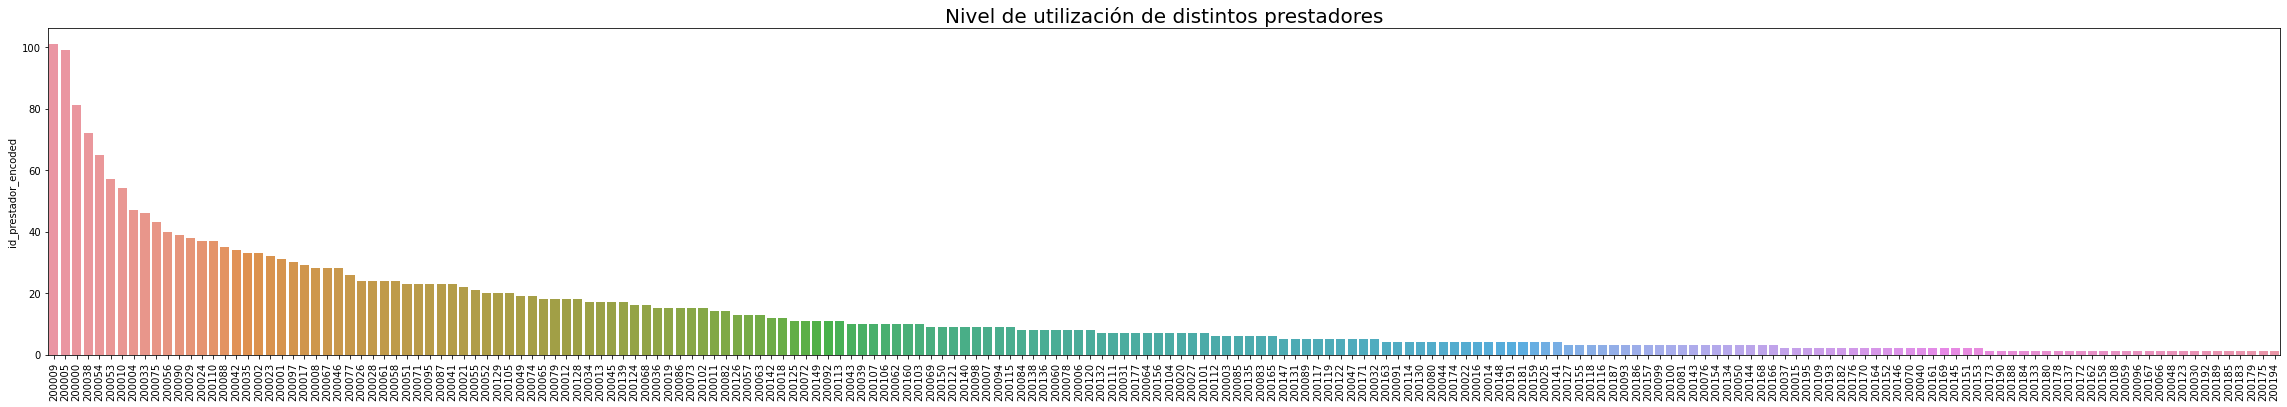

In [499]:
plt.figure(figsize=(40,6))
sns.barplot(x=df.id_prestador_encoded.value_counts().index,y=df.id_prestador_encoded.value_counts(),
           order=df.id_prestador_encoded.value_counts().index)

plt.xticks(rotation=90)
plt.title("Nivel de utilización de distintos prestadores",fontsize=20)
plt.show()

Partiendo del análisis realizado en los laboratorios anteriores, tenemos muchos prestadores que han sido utilizados pocas veces, mientras que hay pocos que han sido utilizados muchas veces.
Vamos a hacer una selección basándonos en medidas de tendencia central de la distribución anterior

In [500]:
df.id_prestador_encoded.value_counts().describe().reset_index()

,index,id_prestador_encoded
0,count,196.0000
1,mean,12.7551
2,std,16.3249
3,min,1.0000
4,25%,3.0000
5,50%,7.0000
6,75%,17.0000
7,max,101.0000


Vamos a filtrar utilizando el percentil 0.42

In [501]:
percetil_42=df.id_prestador_encoded.value_counts().quantile(0.42)
prestadores_interes=df.id_prestador_encoded.value_counts()[df.id_prestador_encoded.value_counts()>percetil_42].index

In [502]:
df_filtrado=df[df.id_prestador_encoded.isin(prestadores_interes)]
df_filtrado.shape

(2272, 37)

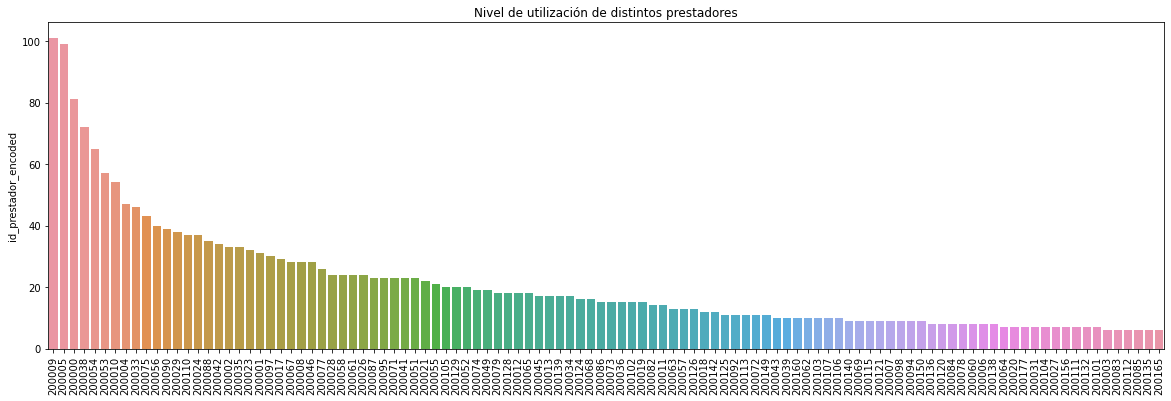

In [503]:
plt.figure(figsize=(20,6))
sns.barplot(x=df_filtrado.id_prestador_encoded.value_counts().index,y=df_filtrado.id_prestador_encoded.value_counts(),
           order=df_filtrado.id_prestador_encoded.value_counts().index)

plt.xticks(rotation=90)
plt.title("Nivel de utilización de distintos prestadores")
plt.show()

### Análisis de consumos de los socios

In [504]:
df_socios_grouped=df_consumos[['id_socio_encoded','id_prestador_encoded']].drop_duplicates()

In [505]:
df_socios_grouped

,id_socio_encoded,id_prestador_encoded
0,100000,200000
2,100001,200001
3,100002,200000
4,100003,200002
5,100004,200003
...,...,...
2491,101919,200042
2492,101920,200024
2494,101921,200058
2495,101922,200053


In [506]:
columns={'id_prestador_encoded':'cantidad_prestadores'}
df_socios_grouped=df_socios_grouped.groupby(['id_socio_encoded'])['id_prestador_encoded'].count().reset_index().rename(columns=columns)
df_socios_grouped.sort_values('cantidad_prestadores',ascending=False)

,id_socio_encoded,cantidad_prestadores
1444,101444,2
262,100262,2
1740,101740,2
296,100296,2
1042,101042,2
...,...,...
639,100639,1
638,100638,1
637,100637,1
636,100636,1


In [507]:
df_filtrado[df_filtrado.id_socio_encoded==101444]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard
1240,1858,101444,200053,0.8889,13,38,0.9167,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1241,1861,101444,200053,0.7778,13,38,0.9167,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1242,1862,101444,200053,1.0000,13,38,0.9167,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1726,1859,101444,200079,0.3333,13,38,0.9167,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1727,1860,101444,200079,0.4444,13,38,0.9167,1,0,0,...,0,1,0,0,0,1,0,1,0,0


Text(0.5, 1.0, 'Variabilidad en los prestadores por socio')

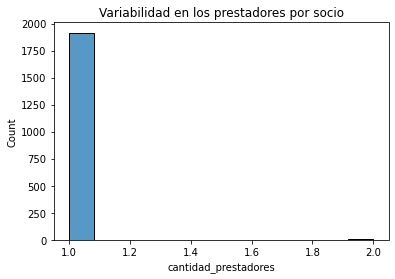

In [508]:
fig,axs=plt.subplots(1,1)
sns.histplot(df_socios_grouped.cantidad_prestadores,ax=axs)
plt.title("Variabilidad en los prestadores por socio")

La gran mayoría de pacientes que ha consumido a un solo médico. Por ejemplo, si el socio 101923 consumió el mismo médico que 100725, y este último no consumió otro distinto..¿que médico puedo recomendar?. Deberé quedarme con los pacientes que tengan médicos que aparezcan en otros pacientes con mayor número de prestadores distintos.

In [466]:
df_socios_grouped[df_socios_grouped.cantidad_prestadores>1]

,id_socio_encoded,cantidad_prestadores
215,100215,2
262,100262,2
296,100296,2
989,100989,2
1042,101042,2
1168,101168,2
1352,101352,2
1444,101444,2
1740,101740,2
1905,101905,2


Sin embargo tenemos solamente 8 pacientes que han consumido mas de un prestador. El abordaje de filtro colaborativo no tiene sentido en este aspecto, por lo que se tendrá que hacer un sistema de recomendación manual.

### Análisis de calificaciones

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


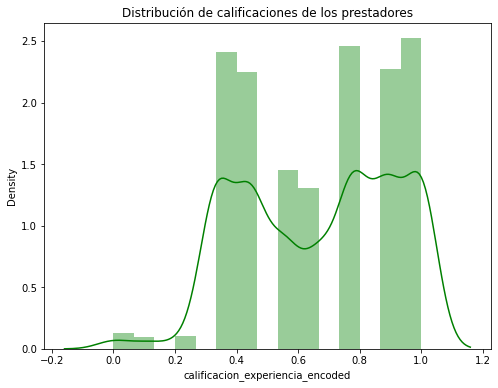

In [509]:
plt.figure(figsize=(8,6))
sns.distplot(df_filtrado.calificacion_experiencia_encoded,color='g')
plt.title("Distribución de calificaciones de los prestadores")
plt.show()

In [510]:
df_filtrado.calificacion_experiencia_encoded.describe().reset_index()

,index,calificacion_experiencia_encoded
0,count,"2,272.0000"
1,mean,0.6647
2,std,0.2486
3,min,0.0000
4,25%,0.4444
5,50%,0.6667
6,75%,0.8889
7,max,1.0000


Vamos a filtrar utilizando el percentil 0.4

In [511]:
percentil_0405=df_filtrado.calificacion_experiencia_encoded.quantile(0.4)

In [512]:
df_filtrado=df_filtrado[df_filtrado.calificacion_experiencia_encoded>percentil_0405]

In [513]:
df_filtrado.shape

(1297, 37)

Nos quedamos con un total de 1297 registros de pacientes para las 3 especialidades. Este grupo de datos considera a los prestadores mas demandados y que posean calificaciones más aceptables.

## Filtrado de variables no importantes

En un primer análisis se tendrán en cuenta todas las variables adicionales. Solamente se quitarán las que no son necesarias para el proceso de modelado

In [514]:
df_filtrado.columns

Index(['id_consumo_encoded', 'id_socio_encoded', 'id_prestador_encoded',
       'calificacion_experiencia_encoded', 'id_zona_encoded', 'edad_encoded',
       'antiguedad_encoded', 'sexo_encoded_F', 'sexo_encoded_M',
       'plan_encoded_a', 'plan_encoded_b', 'plan_encoded_c',
       'segmento_encoded_empresa_tipo_1', 'segmento_encoded_empresa_tipo_2',
       'segmento_encoded_individuo_tipo_1',
       'segmento_encoded_individuo_tipo_2',
       'segmento_encoded_individuo_tipo_3', 'parentesco_encoded_Otro',
       'parentesco_encoded_Titular', 'app_descargada_encoded_NO',
       'app_descargada_encoded_SI', 'especialidad_clinica',
       'especialidad_nutricion', 'especialidad_pediatria', 'edad_cat_0.0',
       'edad_cat_1.0', 'edad_cat_2.0', 'edad_cat_3.0', 'antiguedad_bin_0.0',
       'antiguedad_bin_1.0', 'antiguedad_bin_2.0', 'categoria_prestador_gold',
       'categoria_prestador_silver', 'categoria_prestador_standard',
       'categoria_socio_gold', 'categoria_socio_silver',
    

In [515]:
df_filtrado.drop(['id_consumo_encoded','edad_encoded','antiguedad_encoded'],axis=1,inplace=True)

In [516]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 2260
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id_socio_encoded                   1297 non-null   int64  
 1   id_prestador_encoded               1297 non-null   int64  
 2   calificacion_experiencia_encoded   1297 non-null   float64
 3   id_zona_encoded                    1297 non-null   int64  
 4   sexo_encoded_F                     1297 non-null   int64  
 5   sexo_encoded_M                     1297 non-null   int64  
 6   plan_encoded_a                     1297 non-null   int64  
 7   plan_encoded_b                     1297 non-null   int64  
 8   plan_encoded_c                     1297 non-null   int64  
 9   segmento_encoded_empresa_tipo_1    1297 non-null   int64  
 10  segmento_encoded_empresa_tipo_2    1297 non-null   int64  
 11  segmento_encoded_individuo_tipo_1  1297 non-null   int64

In [518]:
columnas_eliminar=['categoria_socio_silver','categoria_socio_standard','id_prestador_encoded','id_prestador_encoded',
                   'categoria_prestador_silver','categoria_prestador_standard','categoria_prestador_gold','id_zona_encoded'
                   ,'calificacion_experiencia_encoded','app_descargada_encoded_NO','id_prestador_encoded',
                   'parentesco_encoded_Otro','sexo_encoded_F','segmento_encoded_empresa_tipo_2']

# SOM

In [519]:
df_som=df_filtrado.drop(columnas_eliminar,axis=1).drop_duplicates()
df_som.shape

(966, 22)

In [520]:
df_som.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 966 entries, 0 to 2260
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   id_socio_encoded                   966 non-null    int64
 1   sexo_encoded_M                     966 non-null    int64
 2   plan_encoded_a                     966 non-null    int64
 3   plan_encoded_b                     966 non-null    int64
 4   plan_encoded_c                     966 non-null    int64
 5   segmento_encoded_empresa_tipo_1    966 non-null    int64
 6   segmento_encoded_individuo_tipo_1  966 non-null    int64
 7   segmento_encoded_individuo_tipo_2  966 non-null    int64
 8   segmento_encoded_individuo_tipo_3  966 non-null    int64
 9   parentesco_encoded_Titular         966 non-null    int64
 10  app_descargada_encoded_SI          966 non-null    int64
 11  especialidad_clinica               966 non-null    int64
 12  especialidad_nutricio

In [521]:
df_som_test=df_som.sample(100,random_state=0).drop_duplicates()

In [522]:
df_som_test

,id_socio_encoded,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Titular,...,especialidad_nutricion,especialidad_pediatria,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_socio_gold
2247,100959,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
567,100531,1,0,0,1,0,1,0,0,1,...,0,1,1,0,0,0,1,0,0,0
32,100735,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1386,101495,0,0,1,0,0,0,1,0,1,...,0,1,1,0,0,0,0,0,1,0
682,100781,0,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,101476,1,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
967,100728,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
719,100133,0,0,0,1,0,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
2259,101710,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [523]:
df_som_train=df_som[~df_som.index.isin(df_som_test.index)]

In [524]:
df_som_train.set_index('id_socio_encoded',inplace=True)
df_som_test.set_index('id_socio_encoded',inplace=True)

In [525]:
df_som_train.shape

(866, 21)

In [526]:
df_som_train.head(2)

,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Titular,app_descargada_encoded_SI,...,especialidad_nutricion,especialidad_pediatria,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_socio_gold
id_socio_encoded,,,,,,,,,,,,,,,,,,,,,
100000,0,1,0,0,0,1,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
100002,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


## Determinación del número óptimo de clusters

In [527]:
# Preparamos una lista donde vamos a ir agregando las distancias medias
lista_distancias_medias = []
# Entrenamos un modelo para cada numero de cluster que queremos testear
K = np.arange(2,16)
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(df_som_train)
    # Tomamos la suma de las distancias para todas las instancias del dataset
    distancia_total = km.inertia_
    # Calculamos la distancia media y agregamos a la lista
    distancia_media = distancia_total/df_som_train.shape[0]
    lista_distancias_medias.append(distancia_media)

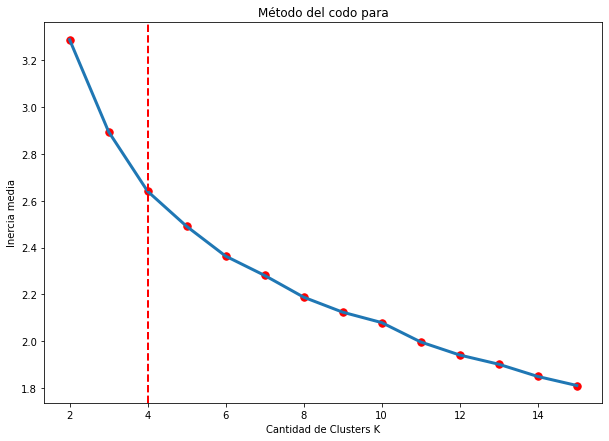

In [528]:
plt.figure(figsize = (10,7))
# Graficamos una linea continua y tambien unos puntos para resaltar los valores enteros de K.
plt.plot(K,lista_distancias_medias, lw=3)
plt.scatter(K,lista_distancias_medias,s=55,c='r')
plt.axvline(x=4,linewidth=2,linestyle="--", color='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para')

plt.show()

Este método no nos proporciona un número adecuado para determinar el número de clusters, lo cual es esperado en un análisis de segmentación de clientes de esta naturaleza. Probablemente sea mejor conseguir variables representativas del negocio para hacer una diferenciación según algun objetivo o característica.

In [529]:
class SOM():
    
    def __init__(self, n_rows, n_columns,lr=0.5,learning_rate=None):
        
 
        self.n_rows = n_rows
        self.n_columns = n_columns
        self.learning_rate=learning_rate if learning_rate is not None else lr
    
    
    def train_predict(self,data):
        
            from minisom import MiniSom
            
            self.data=data.copy()
    
            som = MiniSom(self.n_rows,self.n_columns, self.data.shape[1],learning_rate=self.learning_rate ,sigma=2.,  
                          neighborhood_function='gaussian', random_seed=10)
            som.pca_weights_init(data.values)
            print("Training...")
            som.train_batch(self.data.values, 50000, verbose=True)  # random training
            print("\n...ready!")
            
            self.som=som
            
            winner_coordinates = np.array([self.som.winner(x) for x in self.data.values]).T
            
            self.cluster_index = np.ravel_multi_index(winner_coordinates, (self.n_rows,self.n_columns))
            
            self.labels_maps=som.labels_map(self.data.values, [t for t in self.cluster_index])
            
            self.win_map = self.som.win_map(self.data.values)

            self.data['cluster_index']=self.cluster_index
            
            return np.concatenate(self.som.get_weights())

    
    def color_categorica(self,data_clientes,variable_cat):
        
            from sklearn.preprocessing import MinMaxScaler     
                    
            matrix=np.zeros((self.n_rows,self.n_columns))
    
            for position in self.labels_maps.keys():

                cluster_som=int(list(self.labels_maps[position].keys())[0])
                matrix[position[0],position[1]]=self.data_clientes[self.data_clientes.cluster_index==cluster_som][self.variable_cat].mean()

            flat_matrix=matrix.flatten()
            
            scaler=MinMaxScaler()
            new_matrix=scaler.fit_transform(flat_matrix.reshape(-1,1))

            self.new_matrix=new_matrix.reshape(self.n_rows,self.n_columns)
            
    def plot(self,data_clientes,variable_cat,figsize):
        
        import matplotlib.gridspec as gridspec
        from matplotlib import cm, colorbar
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        from matplotlib.offsetbox import AnchoredText
        
        self.data_clientes=data_clientes.copy()
        self.variable_cat=variable_cat
        
        self.data_clientes=self.data_clientes.merge(self.data[['cluster_index']],right_index=True,left_index=True,how='left')
        
        
        self.color_categorica(self.data_clientes,self.variable_cat)
        
        fig,axs=plt.subplots(nrows=self.n_rows,ncols=self.n_columns,sharex=True,figsize=figsize,sharey=True)
        
        fig.suptitle(self.variable_cat,fontsize=13)
        fig.tight_layout()
    
        for position in self.labels_maps.keys():

            cluster_som=int(list(self.labels_maps[position].keys())[0])

#             axs2 = axs[position[0],position[1]].twinx().twiny()
            
            columns=self.data.columns[:-1]

            axs[position[0],position[1]].plot(columns,np.mean(self.win_map[position], axis=0),color='lime',marker='.',markersize=10)
            
            axs[position[0],position[1]].axhline(y=0, color='tab:gray', linestyle='-')
            
            axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)

            axs[position[0],position[1]].set_facecolor(cm.Blues(self.new_matrix[position[0], position[1]]))
            
            axs[position[0],position[1]].grid()
            
            axs[position[0],position[1]].set_title(cluster_som)

#             axs2.hist(self.data_clientes.margen_porcentual,bins=int(np.sqrt(self.data_clientes[self.data_clientes.cluster_index==cluster_som].shape[0])),
#                                                color='tab:orange')
            
            anchored_text = AnchoredText('Clientes:{} \nMean {}:{:.3f}'.format(self.data_clientes[self.data_clientes.cluster_index==cluster_som].index.nunique(),
                                                                           self.variable_cat,
                                                                               (self.data_clientes[self.data_clientes.cluster_index==cluster_som][self.variable_cat].mean())),
                                         loc=2)
            axs[position[0],position[1]].add_artist(anchored_text)
            
        return self.data_clientes,self.data
    
    def predict(self,x):
        
        winner_coordinates = np.array([self.som.winner(x) for x in x.values]).T
            
        cluster_index = np.ravel_multi_index(winner_coordinates, (self.n_rows,self.n_columns))
        
        return cluster_index

In [530]:
som=SOM(2,2)

In [531]:
centroides=som.train_predict(df_som_train)

C:\Users\arrua\anaconda3\lib\site-packages\minisom.py:154: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


Training...
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 2.054629818681387

...ready!


## Dataframe con datos de clientes

In [532]:
df_data_socios=df[['id_socio_encoded','edad_encoded','antiguedad_encoded','calificacion_experiencia_encoded']].drop_duplicates()

In [533]:
df_data_socios

,id_socio_encoded,edad_encoded,antiguedad_encoded,calificacion_experiencia_encoded
0,100000,81,5.7500,0.6667
1,100000,81,5.7500,0.5556
2,100002,60,6.3333,0.6667
3,100010,43,5.6667,0.6667
4,100017,47,5.8333,0.6667
...,...,...,...,...
2495,101548,3,1.0833,0.2222
2496,101612,5,1.7500,0.1111
2497,101618,3,1.0000,0.1111
2498,101791,8,2.4167,0.1111


In [534]:
df_data_socios.id_socio_encoded.duplicated().sum()

290

Se hace un groupby para obtener los últimos valores de cada socio

In [535]:
df_data_socios=df_data_socios.groupby('id_socio_encoded').agg({
                                                                'edad_encoded':'last',
                                                                'antiguedad_encoded':'last',
                                                                'calificacion_experiencia_encoded':'mean'
                                                                })

In [536]:
df_data_socios

,edad_encoded,antiguedad_encoded,calificacion_experiencia_encoded
id_socio_encoded,,,
100000,81,5.7500,0.6111
100001,64,6.4167,0.7778
100002,60,6.3333,0.6667
100003,49,6.5000,0.8889
100004,48,5.5000,0.2222
...,...,...,...
101919,23,0.5833,1.0000
101920,22,1.8333,0.8889
101921,11,1.8333,1.0000


In [537]:
df_som_train.shape

(866, 21)

In [538]:
df_info_clientes=df_som_train.merge(df_data_socios,left_index=True,right_on='id_socio_encoded',how='left')
df_info_clientes

,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Titular,app_descargada_encoded_SI,...,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_socio_gold,edad_encoded,antiguedad_encoded,calificacion_experiencia_encoded
id_socio_encoded,,,,,,,,,,,,,,,,,,,,,
100000,0,1,0,0,0,1,0,0,1,1,...,0,0,1,0,0,1,0,81,5.7500,0.6111
100002,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,60,6.3333,0.6667
100010,0,1,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,43,5.6667,0.6667
100017,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,47,5.8333,0.6111
100035,0,1,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,42,4.5000,0.6667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101263,0,1,0,0,0,1,0,0,1,1,...,0,0,1,0,1,0,0,81,2.2500,0.9444
101349,0,0,1,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,24,0.3333,0.7778
101399,0,1,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,69,5.0833,0.8889


<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)


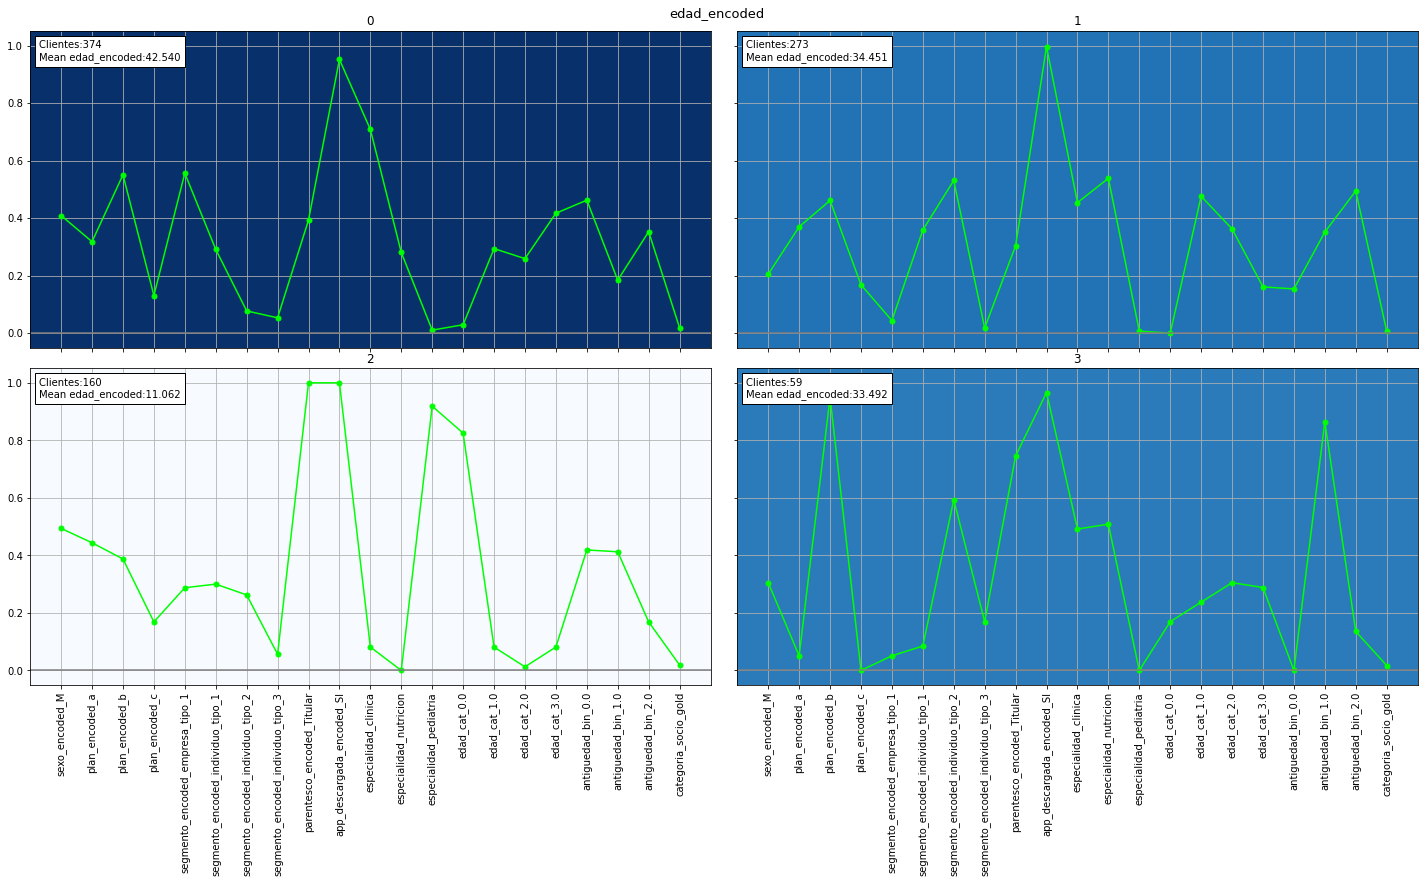

In [539]:
data_socios,data=som.plot(df_info_clientes,'edad_encoded',(20,10))

<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)


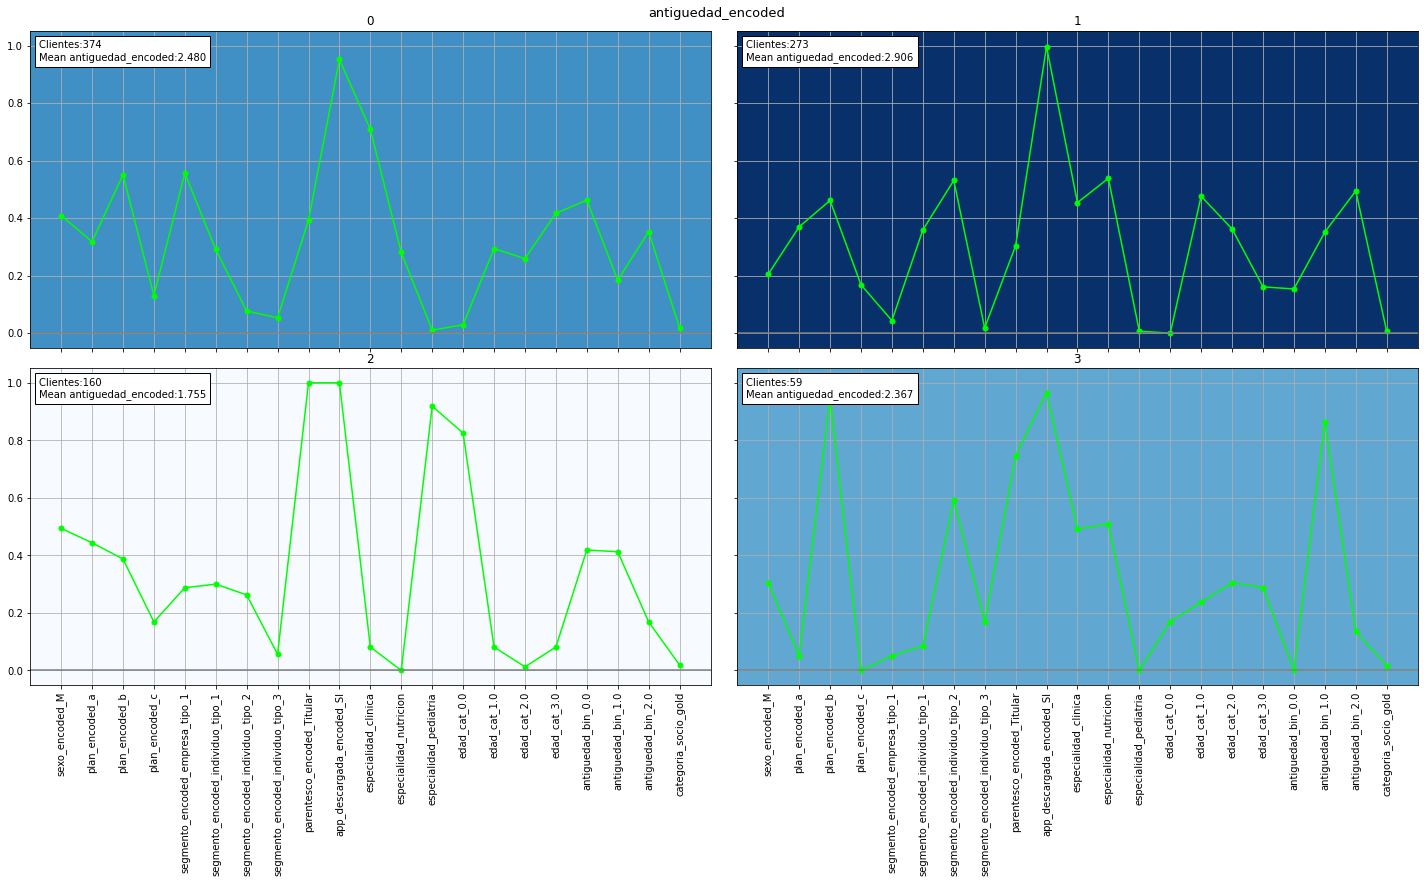

In [540]:
data_socios,data=som.plot(df_info_clientes,'antiguedad_encoded',(20,10))

<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-529-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)


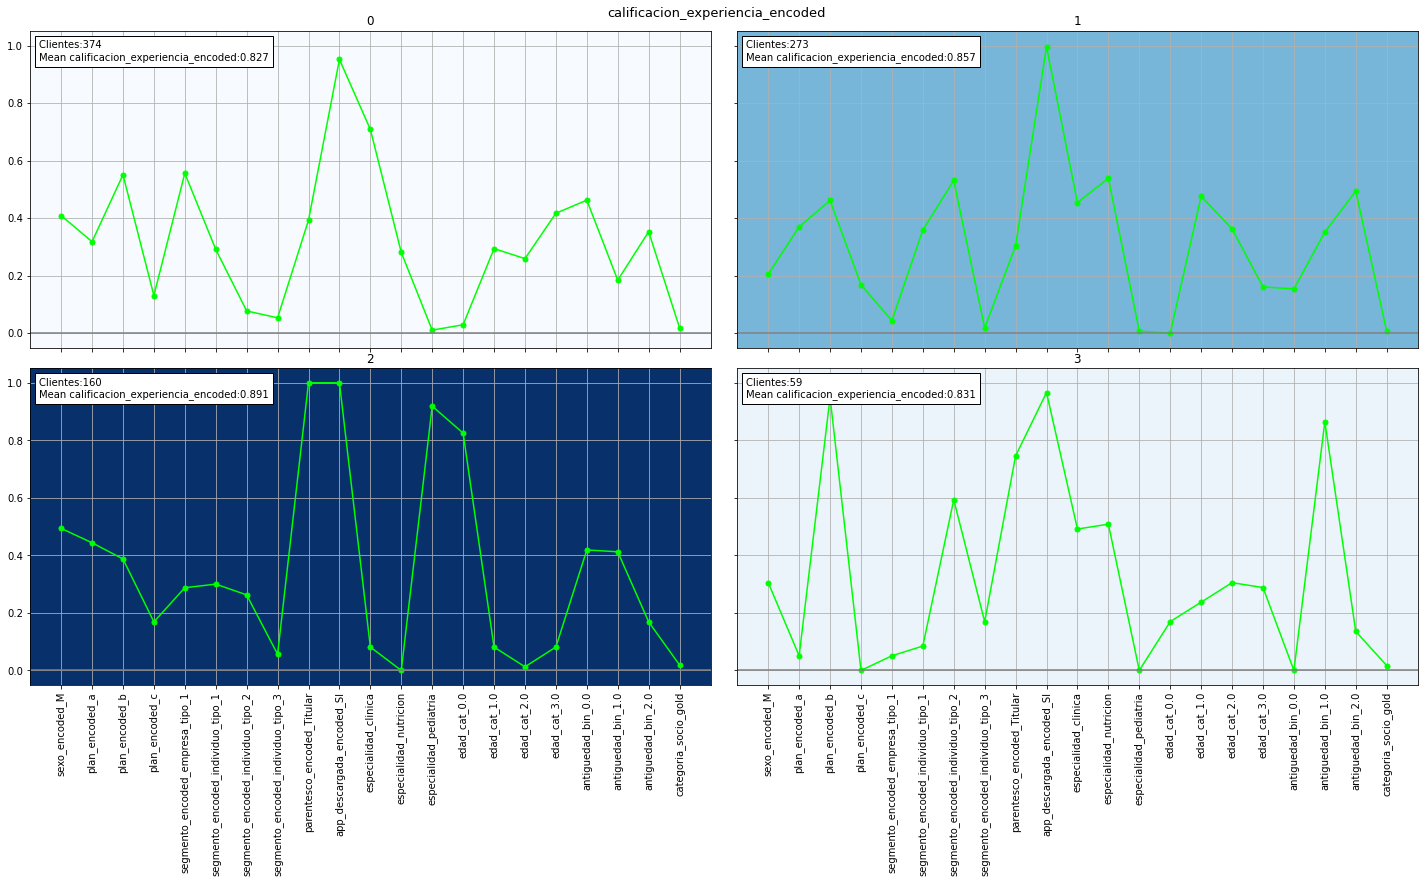

In [541]:
data_socios,data=som.plot(df_info_clientes,'calificacion_experiencia_encoded',(20,10))

In [542]:
df_som_test['prediccion']=som.predict(df_som_test)

In [543]:
df_som_test

,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Titular,app_descargada_encoded_SI,...,especialidad_pediatria,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_socio_gold,prediccion
id_socio_encoded,,,,,,,,,,,,,,,,,,,,,
100959,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
100531,1,0,0,1,0,1,0,0,1,1,...,1,1,0,0,0,1,0,0,0,2
100735,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
101495,0,0,1,0,0,0,1,0,1,1,...,1,1,0,0,0,0,0,1,0,2
100781,0,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101476,1,0,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,1
100728,0,0,1,0,0,0,0,1,0,1,...,0,0,1,0,0,1,0,0,0,0
100133,0,0,0,1,0,0,1,0,1,1,...,0,0,1,0,0,0,1,0,0,1


In [ ]:
def clientes_recomendaciones(df_som_test):
    
    df_som_test['prediccion']=som.predict(df_som_test)

In [544]:
clientes_cluster=data[data.cluster_index==0]

In [545]:
data_cliente=df_som_test[df_som_test.index==100959].values[0]
data_cliente=data_cliente[:-1]

In [546]:
data_cliente

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
      dtype=int64)

In [547]:
clientes_cluster=clientes_cluster[clientes_cluster.columns[:-1]]

In [548]:
clientes_cluster

,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Titular,app_descargada_encoded_SI,...,especialidad_nutricion,especialidad_pediatria,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_socio_gold
id_socio_encoded,,,,,,,,,,,,,,,,,,,,,
100002,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
100017,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
100332,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
100353,1,0,0,1,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,1,0
100384,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100858,0,1,0,0,0,1,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
100885,1,0,1,0,1,0,0,0,1,1,...,0,0,0,0,1,0,0,0,1,0
101349,0,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0


In [549]:
data_cliente

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
      dtype=int64)

In [550]:
from scipy.spatial import distance

distancias=distance.cdist(clientes_cluster.values,data_cliente.reshape(1,-1),metric='jaccard')

In [551]:
clientes_cluster['distancia']=distancias

In [552]:
clientes_cluster.sort_values('distancia')[:30]

,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Titular,app_descargada_encoded_SI,...,especialidad_pediatria,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_socio_gold,distancia
id_socio_encoded,,,,,,,,,,,,,,,,,,,,,
100963,0,0,0,1,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0.2857
101266,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0.2857
101091,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0.2857
100154,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0.2857
101413,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0.2857
101683,1,0,0,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0.3750
101364,1,0,0,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0.3750
100003,0,0,0,1,1,0,0,0,1,1,...,0,0,0,0,1,0,0,1,0,0.3750
100007,0,0,0,1,1,0,0,0,1,1,...,0,0,0,0,1,0,0,1,0,0.3750


In [432]:
clientes_similares=clientes_cluster.sort_values('distancia',ascending=False)[:60].index

In [443]:
df_filtrado[df_filtrado.id_socio_encoded==100902]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,...,id_zona_encoded_17,id_zona_encoded_18,id_zona_encoded_19,id_zona_encoded_20,id_zona_encoded_21,id_zona_encoded_22,id_zona_encoded_23,id_zona_encoded_24,id_zona_encoded_25,id_zona_encoded_26
573,1146,100902,200017,1.0000,16,2.7500,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
574,1147,100902,200017,0.8889,16,2.7500,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
575,1148,100902,200017,0.7778,16,2.7500,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
576,1149,100902,200017,1.0000,16,2.7500,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [444]:
df_filtrado[df_filtrado.id_socio_encoded.isin(clientes_similares)].id_prestador_encoded.unique()

array([200000, 200003, 200005, 200006, 200007, 200009, 200010, 200012,
       200013, 200018, 200024, 200029, 200045, 200049, 200061, 200067,
       200068, 200071, 200077, 200090, 200095, 200103, 200125, 200132,
       200160, 200165], dtype=int64)

# Colaborativo

In [218]:
df_filtrado=df_filtrado[['id_socio_encoded','id_prestador_encoded','calificacion_experiencia_encoded']]
df_filtrado

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded
0,100000,200000,0.6667
2,100002,200000,0.6667
3,100010,200000,0.6667
4,100017,200000,0.6667
7,100035,200000,0.6667
...,...,...,...
2256,101492,200129,1.0000
2257,101682,200129,0.8889
2258,101696,200129,0.8889
2259,101710,200129,0.7778


In [221]:
df_colaborativo=df_filtrado.groupby(['id_socio_encoded','id_prestador_encoded'])['calificacion_experiencia_encoded'].mean().reset_index()
df_colaborativo

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded
0,100000,200000,0.6667
1,100001,200001,0.7778
2,100002,200000,0.6667
3,100003,200002,0.8889
4,100005,200004,1.0000
...,...,...,...
961,101919,200042,1.0000
962,101920,200024,0.8889
963,101921,200058,1.0000
964,101922,200053,0.8056


In [237]:
df_colaborativo.id_socio_encoded.value_counts()

100351    1
101099    1
101035    1
101034    1
101033    1
         ..
101630    1
101627    1
101626    1
101625    1
100352    1
Name: id_socio_encoded, Length: 966, dtype: int64

In [223]:
df_pivot = df_colaborativo.pivot_table(columns='id_socio_encoded', index='id_prestador_encoded', values="calificacion_experiencia_encoded")
df_pivot.fillna(0, inplace=True)
df_pivot

id_socio_encoded,100000,100001,100002,100003,100005,100006,100007,100010,100011,100012,...,101911,101912,101915,101917,101918,101919,101920,101921,101922,101923
id_prestador_encoded,,,,,,,,,,,,,,,,,,,,,
200000,0.6667,0.0000,0.6667,0.0000,0.0000,0.0000,0.0000,0.6667,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200001,0.0000,0.7778,0.0000,0.0000,0.0000,0.8889,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200002,0.0000,0.0000,0.0000,0.8889,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200004,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.7778,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6667,0.0000,0.0000,0.6667,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200008,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7778,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200009,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200010,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
200017,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
